# Logistic regression

In a binary logistic regression model, **the dependent variable has two levels (categorical)**.

Let us try to understand logistic regression by considering a logistic model with given parameters, then seeing how the coefficients can be estimated from data. Consider a model with two predictors, ${\displaystyle x_{1}}$ and ${\displaystyle x_{2}}$, and one binary (Bernoulli) response variable ${\displaystyle Y}$, which we denote ${\displaystyle p=P(Y=1)}$. We assume a **linear relationship between the predictor variables and the log-odds (also called logit) of the event** that ${\displaystyle Y=1}$. This linear relationship can be written in the following mathematical form (where ℓ is the log-odds, ${\displaystyle b}$ is the base of the logarithm, and ${\displaystyle \beta _{i}}$ are parameters of the model):

${\displaystyle \ell =\log _{b}{\frac {p}{1-p}}=\beta _{0}+\beta _{1}x_{1}+\beta _{2}x_{2}}$

We can recover the odds by exponentiating the log-odds:

${\displaystyle {\frac {p}{1-p}}=b^{\beta _{0}+\beta _{1}x_{1}+\beta _{2}x_{2}}}$.

By simple algebraic manipulation (and dividing numerator and denominator by ${\displaystyle b^{\beta _{0}+\beta _{1}x_{1}+\beta _{2}x_{2}}}$), the probability that ${\displaystyle Y=1}$ is:

${\displaystyle p={\frac {b^{\beta _{0}+\beta _{1}x_{1}+\beta _{2}x_{2}}}{b^{\beta _{0}+\beta _{1}x_{1}+\beta _{2}x_{2}}+1}}={\frac {1}{1+b^{-(\beta _{0}+\beta _{1}x_{1}+\beta _{2}x_{2})}}}=S_{b}(\beta _{0}+\beta _{1}x_{1}+\beta _{2}x_{2})}$.

Where ${\displaystyle S_{b}}$ is the sigmoid function with base ${\displaystyle b}$. 

The above formula shows that once ${\displaystyle \beta _{i}}$ are fixed, we can easily compute either the log-odds that ${\displaystyle Y=1}$ for a given observation, or the probability that ${\displaystyle Y=1}$ for a given observation. 

The main use-case of a logistic model is to be given an observation ${\displaystyle (x_{1},x_{2})}$, and estimate the probability ${\displaystyle p}$ that ${\displaystyle Y=1}$. In most applications, the base ${\displaystyle b}$ of the logarithm is usually taken to be e. However in some cases it can be easier to communicate results by working in base 2, or base 10.

(from [Wikipedia](https://en.wikipedia.org/wiki/Logistic_regression))

In Stan: https://mc-stan.org/docs/2_19/functions-reference/bernoulli-logit-distribution.html

And: https://mc-stan.org/docs/2_19/stan-users-guide/logistic-probit-regression-section.html

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.special import expit # inverse of the logit function
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt

sns.set(context = "talk", 
        style = "white", 
        palette = "husl",
        rc={'figure.figsize':(10, 6)})

## Simulating data (1 predictor)

In [9]:
sample_size = 100
x = np.random.normal(0, 4, sample_size) # IV
generating_betas = [-1, .6]
X = sm.add_constant(x)
p = expit(np.sum(generating_betas*X, axis=1))
y = stats.bernoulli.rvs(p) # DV

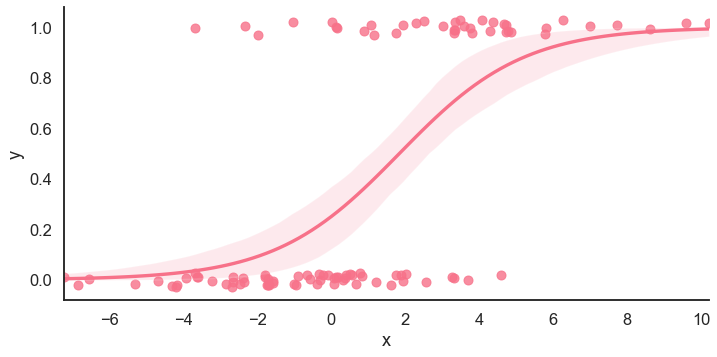

In [10]:
sns.lmplot(x="x", y="y", data=pd.DataFrame({'x':x, 'y':y}), logistic=True, y_jitter=.03, aspect=2);
plt.xlabel("x")
plt.ylabel("y")
sns.despine();

In [16]:
model_code = """

data {
    int<lower=0> N;                  // number of data items
    int<lower=0> K;                  // number of coefficients (1 + n predictors)
    matrix[N, K] X;                  // predictor matrix
    int<lower=0, upper=1> y[N];      // outcome
}
parameters {
    vector[K] beta;       // regression coefficients
}
model {
    beta ~ cauchy(0, 5);          // prior coefficients
    y ~ bernoulli_logit(X * beta);  // likelihood
}

generated quantities {
    vector[N] log_likelihood;
    vector[N] y_hat;
    
    {for (i in 1:N) {
        log_likelihood[i] = bernoulli_logit_lpmf(y[i] | X[i]*beta);      // log likelihood of each data point y[i] 
        y_hat[i] = bernoulli_logit_rng(X[i]*beta);                       // generated data for each sample p
    }
    }
}
"""

In [17]:
data_dict = {'N': sample_size,
             'K': 2,
             'X': X,
             'y': y}

n_iter = 3000
n_warmup = 1000
n_chains = 2

In [18]:
import pystan

In [19]:
fit = pystan.stan(model_code=model_code, 
                  data=data_dict,
                  iter=n_iter, 
                  warmup=n_warmup,
                  chains=n_chains)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_01a6b154437d698ea5951b67d325afb9 NOW.


In [20]:
import arviz as az

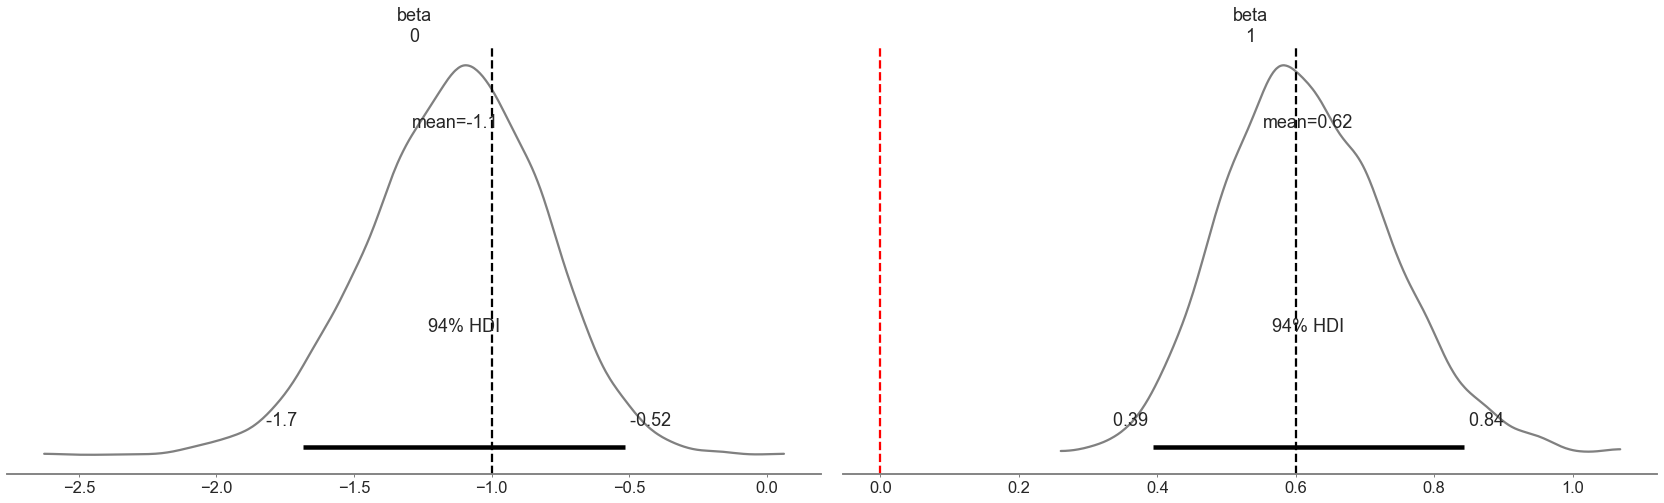

In [21]:
g = az.plot_posterior(fit, var_names=["beta"], color='grey');

g[0].axvline(generating_betas[0], color='k', linestyle='--');
g[1].axvline(generating_betas[1], color='k', linestyle='--');
g[1].axvline(0, color='red', linestyle='--');

**ON YOUR OWN:** Now try to add another predictor (e.g., `x = np.random.normal(0, 1, (sample_size, 2))` with coefficient $\beta$=.1. Rerun the model. What do you observe?

## Real data

Download the **Health care: Data set on Heart attack possibility** (`heart.csv`) from https://www.kaggle.com/nareshbhat/health-care-data-set-on-heart-attack-possibility?select=heart.csv

Attribute Information
1) age
2) sex
3) chest pain type (4 values)
4) resting blood pressure
5) serum cholestoral in mg/dl
6)fasting blood sugar > 120 mg/dl
7) resting electrocardiographic results (values 0,1,2)
8) maximum heart rate achieved
9) exercise induced angina
10) oldpeak = ST depression induced by exercise relative to rest
11)the slope of the peak exercise ST segment
12) number of major vessels (0-3) colored by flourosopy
13) thal: 0 = normal; 1 = fixed defect; 2 = reversable defect
14) target: 0= less chance of heart attack 1= more chance of heart attack

In [27]:
import pandas as pd
data = pd.read_csv('/Users/laurafontanesi/git/bayesian_est_workshop/data/heart.csv')
data.shape

(303, 14)

In [28]:
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


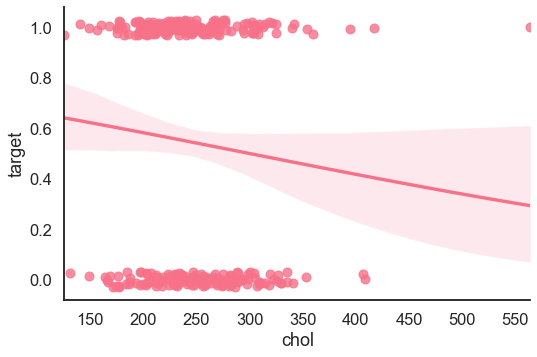

In [36]:
sns.lmplot(x="chol", y="target", data=data, logistic=True, y_jitter=.03, aspect=1.5);
sns.despine();

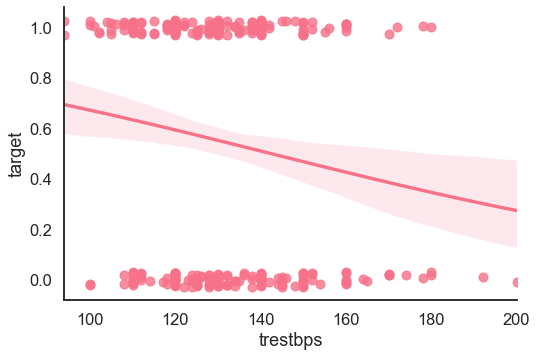

In [37]:
sns.lmplot(x="trestbps", y="target", data=data, logistic=True, y_jitter=.03, aspect=1.5);
sns.despine();

In [38]:
sample_size = data.shape[0]
x = data[['chol', 'trestbps']].values
X = sm.add_constant(x)
y = data['target'].values

In [33]:
data_dict = {'N': sample_size,
             'K': 3,
             'X': X,
             'y': y}

n_iter = 3000
n_warmup = 1000
n_chains = 2

In [34]:
fit = pystan.stan(model_code=model_code, 
                  data=data_dict,
                  iter=n_iter, 
                  warmup=n_warmup,
                  chains=n_chains)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_01a6b154437d698ea5951b67d325afb9 NOW.


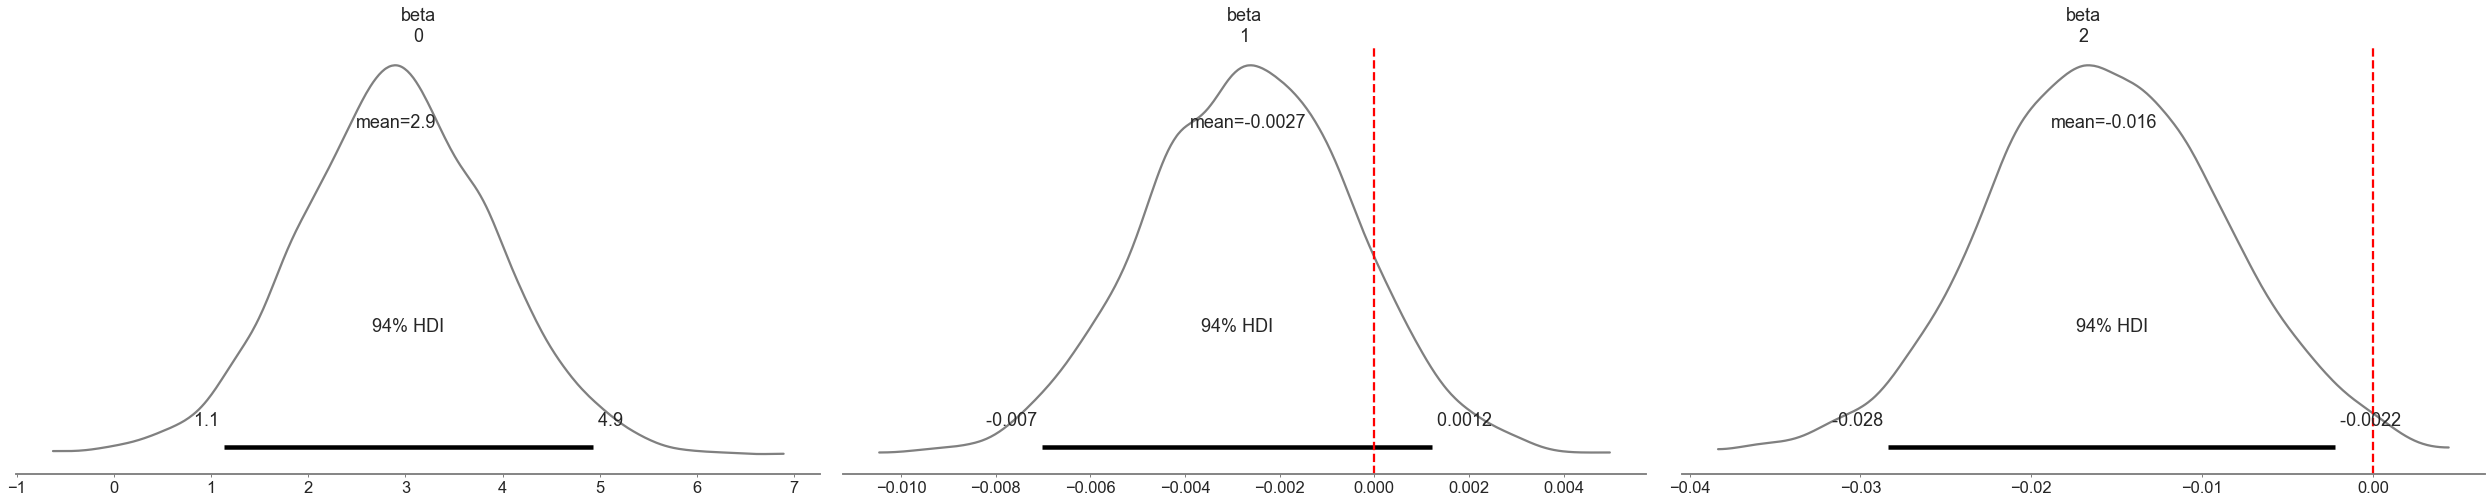

In [35]:
g = az.plot_posterior(fit, var_names=["beta"], color='grey');

g[1].axvline(0, color='red', linestyle='--')
g[2].axvline(0, color='red', linestyle='--');

**ON YOUR OWN:** 
- How would you interpret these results?
- Optional: compare the results with MLE results using `statsmodels`.
- Optional: visualize posterior predictives on the same data/ on a different pool of data.